In [1]:
import os
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt
from shapely.ops import unary_union

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(b) the straight archipelagic baselines, from which the breadths of marine zones are measured for 
Palauan Archipelago, shall drawn from the northernmost point of Ngeruangel Reef, thence east to the 
northernmost point of Kayangel Island and around the island to its easternmost point, south to the 
easternmost point of the Babeldaob barrier reef, south to the easternmost point of Anguar Island and 
then around the island to its westernmost point, thence north to the westernmost point of Ngeruangel Reef 
and then around the reef to the point of origin. The normal baselines, from which the breaths of maritime zones
for the Southwest islands are measured shall be drawn around the islands of Fanna, Sonsorol (Dongosaro), Pulo Anna 
and Merir, and the Island of Hatohobei (Tobi Island), including Hocharihic (Helen's Reef).

In [ ]:
#Ngeruangel Reef (Northernmost) x
#Kayangel Island (Northernmost and Eastern most) x
#Babeldaob barrier reef (south to the eastern most point)
#Anguar Island (south to the easternmost point) - (and around the island to its westernmost point) x
#Ngeruangel Reef (north to the westernmost point) - (and then around the reef to the point of origin) x

#List of Southwest Islands
#Fanna
#Sonsorol (Dongosaro)
#Pulo Anna and Merir
#Hatohobei (Tobi Island) 
    #- including Hocharihic (Helen's Reef)

In [2]:
political_boundary = gpd.read_file('pw_plrs_all_political_bndry.json')


In [3]:
from pyproj import Proj, Transformer
proj_in = Proj("EPSG:32653")
proj_out = Proj("EPSG:4326")
transformer = Transformer.from_proj(proj_in, proj_out)
#69230.242 333689.062
geometry_list = []

for x in political_boundary['geometry']:

    if str(type(x)) == "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
        point_list = []
        multi_list = []
        for i in x.geoms:
            for point in list(i.exterior.coords):
                
                x_deg, y_deg = transformer.transform(point[0], point[1])
                point_list.append(geometry.Point(y_deg,x_deg))  
                    
                    
                    
            multi_list.append(geometry.Polygon(point_list))
        geometry_list.append(geometry.MultiPolygon(multi_list))
political_boundary = political_boundary.set_crs(crs="EPSG:4326", allow_override=True)
political_boundary['geometry'] = geometry_list

In [4]:
kayangel = political_boundary[political_boundary['state'] == "Kayangel"]

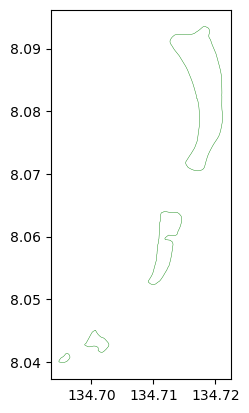

In [5]:
fig, ax = plt.subplots()

# sbc_gdf['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
kayangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
plt.show()

In [6]:
angaur  = political_boundary[political_boundary['state'] == "Angaur"]


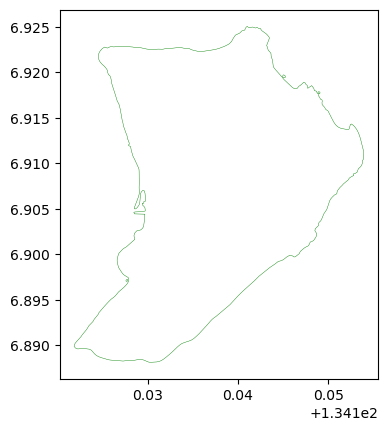

In [7]:
fig, ax = plt.subplots()

angaur['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

plt.show()

In [8]:
cons_sites = gpd.read_file('pw_plrs_all_conservsites.json')


In [9]:
ngeruangel = cons_sites.iloc[[cons_sites.geometry.y.idxmax()], :].to_crs(epsg=4326)

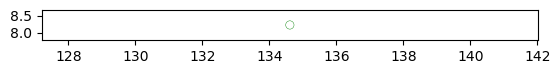

In [10]:
fig, ax = plt.subplots()

ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

plt.show()

In [11]:
coral_reefs = gpd.read_file('pw_unepwcmc_all_coralreefs.json')
reefs = coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic island")]

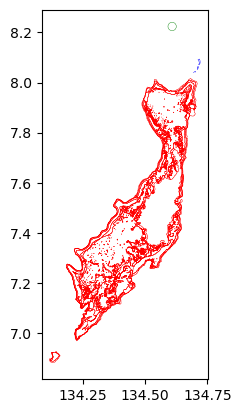

In [12]:
fig, ax = plt.subplots()

ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

reefs['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)


plt.show()

In [13]:
buffered_ngeruangel = ngeruangel.copy()
buffered_ngeruangel = buffered_ngeruangel.to_crs(epsg=3395)
buffered_ngeruangel['geometry'] = buffered_ngeruangel.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_ngeruangel = buffered_ngeruangel.to_crs(epsg=4326)

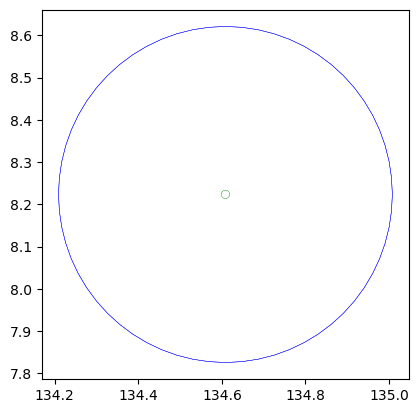

In [14]:
fig, ax = plt.subplots()

ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
buffered_ngeruangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)
buffered_ngeruangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)


plt.show()

In [35]:
# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_groups = []
for idx, circle1 in buffered_ngeruangel.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_ngeruangel.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            nonoverlapping_groups.append(idx)

# Merge overlapping circles into single shapes
merged_shapes = []
for group in overlapping_groups:
    shapes_to_merge = [buffered_ngeruangel.loc[idx].geometry for idx in group]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Retrieve non-overlapping shapes
nonmerged_shapes = [buffered_ngeruangel.loc[group].geometry for group in nonoverlapping_groups]

# Create a new GeoDataFrame with merged shapes
merged_ngeruangel = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_ngeruangel.crs)

In [15]:
buffered_kayangel = kayangel.copy()
buffered_kayangel = buffered_kayangel.to_crs(epsg=3395)
buffered_kayangel['geometry'] = buffered_kayangel.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_kayangel = buffered_kayangel.to_crs(epsg=4326)

In [16]:
# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_groups = []
for idx, circle1 in buffered_kayangel.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_kayangel.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            nonoverlapping_groups.append(idx)

# Merge overlapping circles into single shapes
merged_shapes = []
for group in overlapping_groups:
    shapes_to_merge = [buffered_kayangel.loc[idx].geometry for idx in group]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Retrieve non-overlapping shapes
nonmerged_shapes = [buffered_kayangel.loc[group].geometry for group in nonoverlapping_groups]

# Create a new GeoDataFrame with merged shapes
merged_kayangel = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_kayangel.crs)

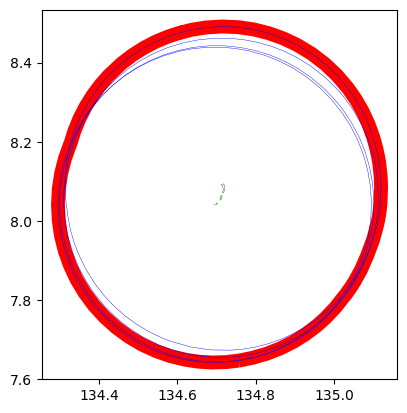

In [17]:
fig, ax = plt.subplots()

kayangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
merged_kayangel['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=10)
buffered_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)


plt.show()

In [18]:
buffered_angaur = angaur.copy()
buffered_angaur = buffered_angaur.to_crs(epsg=3395)
buffered_angaur['geometry'] = buffered_angaur.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_angaur = buffered_angaur.to_crs(epsg=4326)

In [19]:
# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_groups = []
for idx, circle1 in buffered_angaur.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_angaur.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            nonoverlapping_groups.append(idx)

# Merge overlapping circles into single shapes
merged_shapes = []
for group in overlapping_groups:
    shapes_to_merge = [buffered_angaur.loc[idx].geometry for idx in group]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Retrieve non-overlapping shapes
nonmerged_shapes = [buffered_angaur.loc[group].geometry for group in nonoverlapping_groups]

# Create a new GeoDataFrame with merged shapes
merged_angaur = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_angaur.crs)

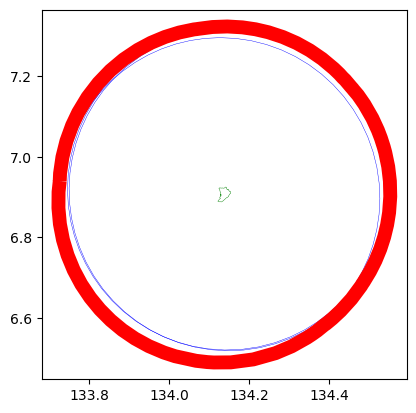

In [20]:
fig, ax = plt.subplots()

angaur['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
buffered_angaur['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)
merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=10)

plt.show()

In [21]:
buffered_reefs = reefs.copy()
buffered_reefs = buffered_reefs.to_crs(epsg=3395)
buffered_reefs['geometry'] = buffered_reefs.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_reefs = buffered_reefs.to_crs(epsg=4326)

In [22]:
# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_groups = []
for idx, circle1 in buffered_reefs.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_reefs.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            nonoverlapping_groups.append(idx)

# Merge overlapping circles into single shapes
merged_shapes = []
for group in overlapping_groups:
    shapes_to_merge = [buffered_reefs.loc[idx].geometry for idx in group]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Retrieve non-overlapping shapes
nonmerged_shapes = [buffered_reefs.loc[group].geometry for group in nonoverlapping_groups]

# Create a new GeoDataFrame with merged shapes
merged_reefs = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_reefs.crs)


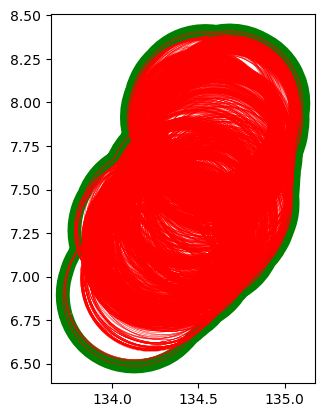

In [23]:
fig, ax = plt.subplots()

merged_reefs['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=10)
buffered_reefs['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

plt.show()

In [24]:
buffered_political_boundary = political_boundary.copy()
buffered_political_boundary = buffered_political_boundary.to_crs(epsg=3395)
buffered_political_boundary['geometry'] = buffered_political_boundary.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_political_boundary = buffered_political_boundary.to_crs(epsg=4326)

In [25]:
# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_groups = []
for idx, circle1 in buffered_political_boundary.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_political_boundary.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            print(circle1.geometry)
            nonoverlapping_groups.append(idx)
            
            
# Merge overlapping circles into single shapes
merged_shapes = []
for group in overlapping_groups:
    shapes_to_merge = [buffered_political_boundary.loc[idx].geometry for idx in group]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Retrieve non-overlapping shapes
nonmerged_shapes = [buffered_political_boundary.loc[group].geometry for group in nonoverlapping_groups]

# Create a new GeoDataFrame with merged shapes
merged_political_boundary = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_political_boundary.crs)

In [26]:
# Define a function to check for overlapping circles
def find_overlapping_circles(buffered_gdf):
    overlapping_groups = []
    nonoverlapping_groups = []
    for idx, circle1 in buffered_gdf.iterrows():
        if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
            overlaps = [idx]
            for jdx, circle2 in buffered_gdf.iterrows():
                if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                    overlaps.append(jdx)
            if len(overlaps) > 1:  # Only consider merging if there are overlaps
                overlapping_groups.append(overlaps)
            else:
                nonoverlapping_groups.append(idx)
    return overlapping_groups, nonoverlapping_groups

In [27]:
# Identify overlapping circles
overlapping_groups = True

merged_political_boundary = buffered_political_boundary
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_political_boundary)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_political_boundary.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_political_boundary.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_political_boundary = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_political_boundary.crs)


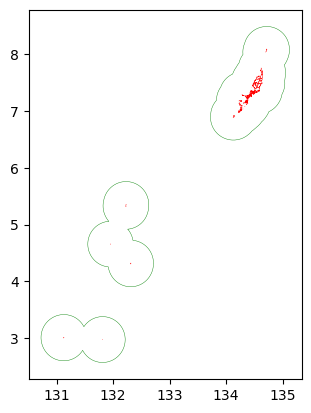

In [28]:
fig, ax = plt.subplots()

merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

plt.show()

In [29]:
merged_political_boundary

,geometry
0,"POLYGON ((132.34870 4.72099, 132.36700 4.71935..."
1,"POLYGON ((133.72611 6.93929, 133.72700 6.95894..."
2,"POLYGON ((131.63588 3.33601, 131.67349 3.35220..."


In [30]:
merged_shapes

[]

In [31]:
nonoverlapping_groups

[0, 1, 2]

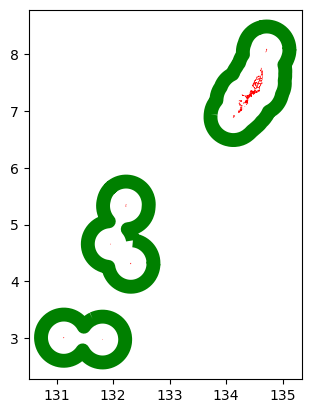

In [32]:
fig, ax = plt.subplots()

merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=10)
political_boundary['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

plt.show()

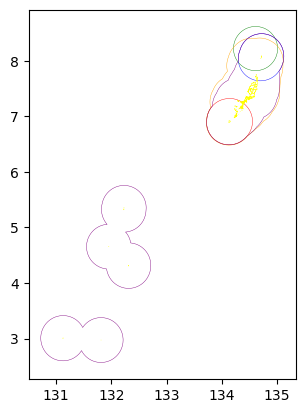

In [36]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)

merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=0.3)

political_boundary['geometry'].plot(ax=ax, edgecolor = "yellow", facecolor= "none",lw=0.3)


plt.show()

In [37]:
merged_ngeruangel['geometry']

0    POLYGON ((135.00776 8.22350, 135.00584 8.18451...
Name: geometry, dtype: geometry

In [38]:
merged_ngeruangel['geometry'][0].bounds

(134.2091939700664, 7.825514408030413, 135.00776032503728, 8.621080910005924)

In [39]:
#Ngeruangel Reef (Northernmost)
north_ngeruangel = ()
maxy = merged_ngeruangel['geometry'][0].bounds[3]
for x, y in merged_ngeruangel['geometry'][0].exterior.coords:
    if y == maxy:
        north_ngeruangel = (x, y)
print(north_ngeruangel)

(134.60847714755184, 8.621080910005924)


In [40]:
merged_kayangel['geometry']

0    POLYGON ((134.75759 7.64658, 134.72256 7.64265...
Name: geometry, dtype: geometry

In [41]:
#Kayangel 
merged_kayangel['geometry'][0].bounds

(134.2954794783873, 7.641815000560817, 135.12039132670753, 8.491234027498425)

In [42]:
#Kayangel Reef (Northernmost)
north_kayangel = ()
maxy = merged_kayangel['geometry'][0].bounds[3]
for x, y in merged_kayangel['geometry'][0].exterior.coords:
    if y == maxy:
        north_kayangel = (x, y)
print(north_kayangel)

#Ngeruangel Reef (Easternmost)
east_kayangel = ()
maxx = merged_kayangel['geometry'][0].bounds[2]
for x, y in merged_kayangel['geometry'][0].exterior.coords:
    if x == maxx:
        east_kayangel = (x, y)
print(east_kayangel)

(134.71430962892484, 8.491234027498425)
(135.12039132670753, 8.085105118311223)


In [43]:
merged_reefs

,geometry
0,"POLYGON ((133.73335 6.77734, 133.73102 6.78420..."


In [44]:
merged_reefs['geometry'][0].bounds

(133.7154673489983, 6.484193832324139, 135.1085237491361, 8.413494274882552)

In [45]:
# #Babeldaob Reef (Southmost)
# north_reefs = ()
# miny = merged_reefs['geometry'][0].bounds[1]
# for x, y in merged_reefs['geometry'][0].exterior.coords:
#     if y == miny:
#         north_reefs = (x, y)
# print(north_reefs)

#Babeldaob Reef (Easternmost)
east_reefs = ()
maxx = merged_reefs['geometry'][0].bounds[2]
for x, y in merged_reefs['geometry'][0].exterior.coords:
    if x == maxx:
        east_reefs = (x, y)
print(east_reefs)

(135.1085237491361, 7.994834104793359)


In [144]:
merged_angaur['geometry'][0].bounds

(133.72293912162104, 6.489363256006662, 134.55309476820742, 7.323864136180595)

In [46]:
#Angaur Island (Easternmost)
east_angaur = ()
maxx = merged_angaur['geometry'][0].bounds[2]
for x, y in merged_angaur['geometry'][0].exterior.coords:
    if x == maxx:
        east_angaur = (x, y)
print(east_angaur)

#Angaur Island (Westernmost)
west_angaur  = ()
minx = merged_angaur['geometry'][0].bounds[0]
for x, y in merged_angaur['geometry'][0].exterior.coords:
    if x== minx:
        west_angaur = (x, y)
print(west_angaur)

(134.55309476820742, 6.901668582454641)
(133.72293912162104, 6.87311695838096)


In [47]:
#Ngeruangel Reef (Westernmost)
west_ngeruangel = ()
minx = merged_ngeruangel['geometry'][0].bounds[0]
for x, y in merged_ngeruangel['geometry'][0].exterior.coords:
    if x == minx:
        west_ngeruangel = (x, y)
print(west_ngeruangel)

(134.2091939700664, 8.223499834450735)


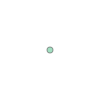

In [48]:
geometry.Point(west_ngeruangel)

In [49]:

tuple_list = [north_ngeruangel,north_kayangel,east_kayangel,east_reefs,east_angaur,west_angaur,west_ngeruangel, north_ngeruangel]

pointList = [geometry.Point(place) for place in tuple_list]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

sdf = pd.DataFrame(
    {
        "Country": ["Palau"],
        "geometry": [poly
        ],
    }
)
bb = gpd.GeoDataFrame(sdf, geometry="geometry")

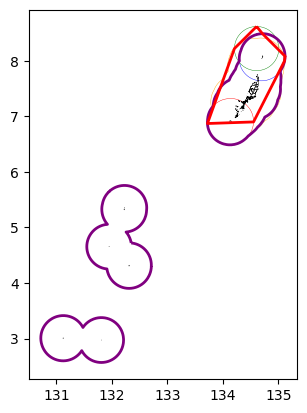

In [50]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)

merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=2)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)



plt.show()

§l4l. Baselines.
A baseline is a continuous line which encircles an
island or atoll. The baseline from which the zones
designated in this chapter are to be measured is as follows:
(a) The baseline of an island or portion of an
island lacking a barrier reef, fringing reef, or other
reef system is the low water line of the island as
marked on large scale charts officially recognized by
the national government.
(b) The baseline of an atoll or island or: portion
of an island having a barrier reef, fringing reef. or
other reef system is a line following the contour of the
seaward edge of the reef system. which line connects
those outermost elevations of the reef which are above
water at low tide, and which line exists 8S ma~ked on
large scale charts officially recognized by the national
government.

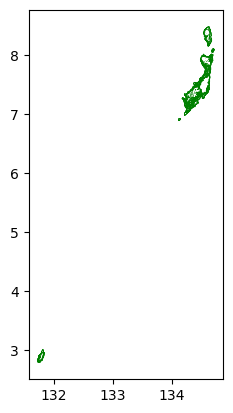

In [51]:
fig, ax = plt.subplots()


coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic island")|(coral_reefs['l2_attrib'] == "Oceanic atoll")].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)
plt.show()

In [52]:
oceanic_reefs = coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic island")|(coral_reefs['l2_attrib'] == "Oceanic atoll")]

buffered_oceanic_reefs = oceanic_reefs.copy()
buffered_oceanic_reefs = buffered_oceanic_reefs.to_crs(epsg=3395)
buffered_oceanic_reefs['geometry'] = buffered_oceanic_reefs.buffer(24 * 1852)  # 1 nautical mile = 1852 meters
buffered_oceanic_reefs = buffered_oceanic_reefs.to_crs(epsg=4326)

In [53]:
# Identify overlapping circles
overlapping_groups = True

merged_oceanic_reefs = buffered_oceanic_reefs
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_oceanic_reefs)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_oceanic_reefs.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_oceanic_reefs.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_oceanic_reefs = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_oceanic_reefs.crs)


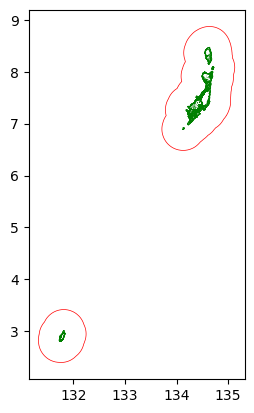

In [54]:
fig, ax = plt.subplots()


coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic island")|(coral_reefs['l2_attrib'] == "Oceanic atoll")].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_oceanic_reefs.plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.5)
plt.show()

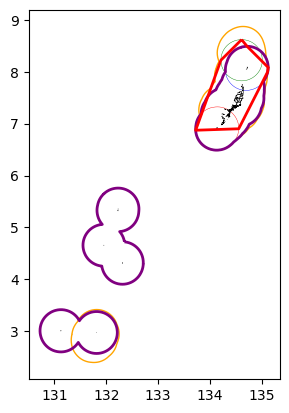

In [55]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

# merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)
merged_oceanic_reefs.plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=1)


merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=2)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)



plt.show()

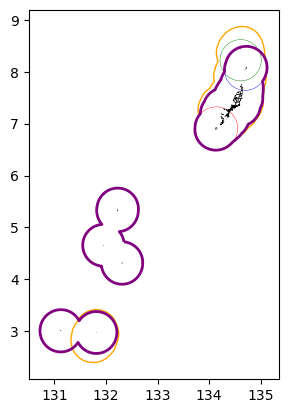

In [56]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

# merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)
merged_oceanic_reefs.plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=1)


merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=2)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

# bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)



plt.show()

In [57]:
contiguous_zone = pd.concat([merged_ngeruangel,merged_kayangel,merged_angaur,merged_oceanic_reefs,merged_political_boundary], ignore_index=True)

In [58]:
contiguous_zone

,geometry
0,"POLYGON ((135.00776 8.22350, 135.00584 8.18451..."
1,"POLYGON ((134.75759 7.64658, 134.72256 7.64265..."
2,"POLYGON ((133.72611 6.93929, 133.72700 6.95894..."
3,"POLYGON ((133.73335 6.77734, 133.73102 6.78420..."
4,"POLYGON ((131.32542 2.77665, 131.32455 2.78275..."
5,"POLYGON ((132.34870 4.72099, 132.36700 4.71935..."
6,"POLYGON ((133.72611 6.93929, 133.72700 6.95894..."
7,"POLYGON ((131.63588 3.33601, 131.67349 3.35220..."


In [59]:
# Identify overlapping circles
overlapping_groups = True

merged_contiguous_zone = contiguous_zone
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_contiguous_zone)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_contiguous_zone.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_contiguous_zone.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_contiguous_zone = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=contiguous_zone.crs)


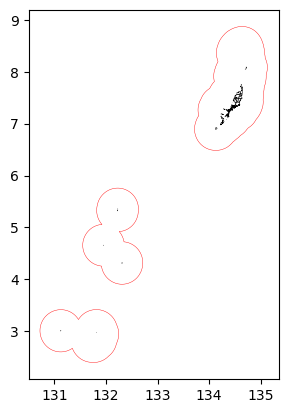

In [60]:
fig, ax = plt.subplots()


merged_contiguous_zone['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

plt.show()

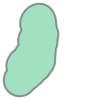

In [61]:
merged_contiguous_zone['geometry'][0]

In [62]:
short_buffered_political_boundary = political_boundary.copy()
short_buffered_political_boundary = short_buffered_political_boundary.to_crs(epsg=3395)
short_buffered_political_boundary['geometry'] = short_buffered_political_boundary.buffer(12 * 1852)  # 1 nautical mile = 1852 meters
short_buffered_political_boundary = short_buffered_political_boundary.to_crs(epsg=4326)

In [63]:
# Identify overlapping circles
overlapping_groups = True

short_merged_political_boundary = short_buffered_political_boundary
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(short_merged_political_boundary)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [short_merged_political_boundary.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [short_merged_political_boundary.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    short_merged_political_boundary = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=short_buffered_political_boundary.crs)


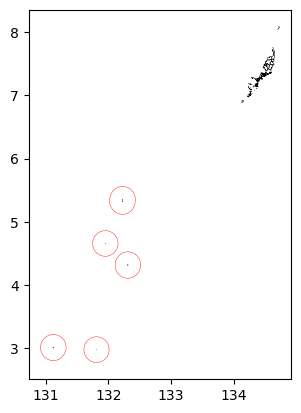

In [64]:
fig, ax = plt.subplots()


short_merged_political_boundary['geometry'][1:].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

plt.show()

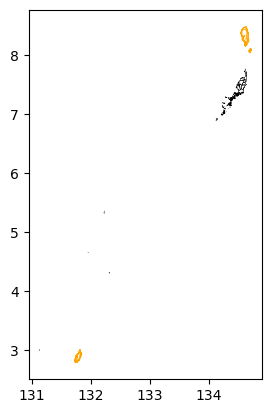

In [65]:
fig, ax = plt.subplots()

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic atoll")].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)

plt.show()

In [66]:
oceanic_atoll = coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic atoll")]

buffered_oceanic_atoll = oceanic_atoll.copy()
buffered_oceanic_atoll = buffered_oceanic_atoll.to_crs(epsg=3395)
buffered_oceanic_atoll['geometry'] = buffered_oceanic_atoll.buffer(12 * 1852)  # 1 nautical mile = 1852 meters
buffered_oceanic_atoll = buffered_oceanic_atoll.to_crs(epsg=4326)

In [67]:
# Identify overlapping circles
overlapping_groups = True

merged_oceanic_atoll = buffered_oceanic_atoll
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_oceanic_atoll)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_oceanic_atoll.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_oceanic_atoll.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_oceanic_atoll = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=buffered_oceanic_atoll.crs)


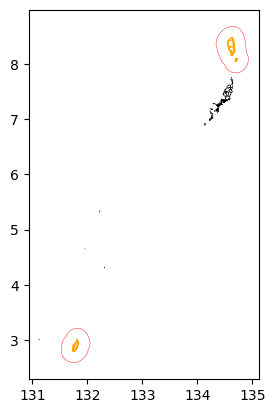

In [68]:
fig, ax = plt.subplots()

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

coral_reefs[(coral_reefs['l2_attrib'] == "Oceanic atoll")].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)


merged_oceanic_atoll.plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

plt.show()

In [69]:
merged_contiguous_zone['geometry'][0:1]

0    POLYGON ((133.73335 6.77734, 133.73102 6.78420...
Name: geometry, dtype: geometry

In [70]:
cont_zone_list = [merged_contiguous_zone[0:1],merged_oceanic_atoll[1:2],short_merged_political_boundary[1:]]

In [71]:
final_cont = pd.concat(cont_zone_list, ignore_index=True)

In [72]:
final_cont

,geometry
0,"POLYGON ((133.73335 6.77734, 133.73102 6.78420..."
1,"POLYGON ((131.52472 2.85297, 131.52536 2.86400..."
2,"POLYGON ((132.01990 5.31797, 132.01933 5.32677..."
3,"POLYGON ((130.93133 2.94266, 130.92552 2.96326..."
4,"POLYGON ((131.61202 2.96863, 131.61171 2.97417..."
5,"POLYGON ((131.90301 4.85196, 131.92124 4.85570..."
6,"POLYGON ((132.12646 4.22659, 132.12472 4.23001..."


In [188]:
# Identify overlapping circles
overlapping_groups = True

merged_final_cont = final_cont
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_final_cont)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_final_cont.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_final_cont.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_final_cont = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=final_cont.crs)


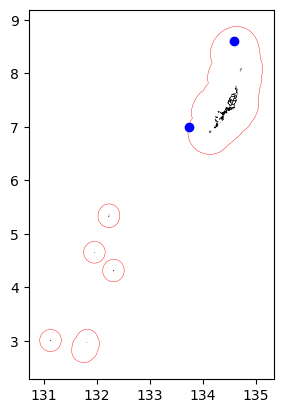

In [74]:
fig, ax = plt.subplots()

#merged hatohobei and hocharihie
merged_final_cont['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
#8.608144 134.581725
#7.00000 133.727181

# Define the coordinates of the points
points_coords = [(8.608144, 134.581725), (7.00000, 133.727181)]

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for y, x in points_coords], crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='blue', marker='o')

plt.show()

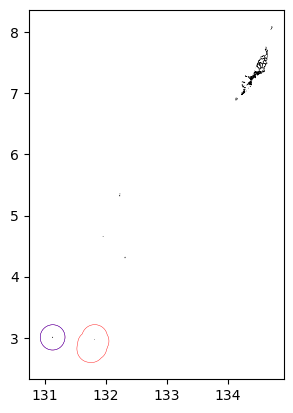

In [90]:
fig, ax = plt.subplots()

#merged hatohobei and hocharihie
merged_final_cont['geometry'][[0,3]].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
# merged_final_cont['geometry'][[3]].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

#8.608144 134.581725
#7.00000 133.727181

plt.show()

In [76]:
merged_final_cont['geometry'][[0,3]]

0    POLYGON ((131.52472 2.85297, 131.52536 2.86400...
3    POLYGON ((130.93133 2.94266, 130.92552 2.96326...
Name: geometry, dtype: geometry

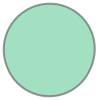

In [88]:
merged_final_cont['geometry'][3]

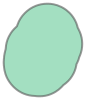

In [87]:
merged_final_cont['geometry'][0]

In [82]:
from shapely.ops import nearest_points
pt1, pt2 = nearest_points(merged_final_cont['geometry'][0], merged_final_cont['geometry'][3])

In [95]:
merged_final_cont['geometry'][0].xmin

AttributeError: 'Polygon' object has no attribute 'xmin'

In [104]:
merge_bounds = []

maxy = merged_final_cont['geometry'][0].bounds[3]
for x, y in merged_final_cont['geometry'][0].exterior.coords:
    if y == maxy:
        first = Point(x,y)
        merge_bounds.append(Point(x,y))
        

        

maxy = merged_final_cont['geometry'][3].bounds[3]
for x, y in merged_final_cont['geometry'][3].exterior.coords:
    if y == maxy:
        merge_bounds.append(Point(x,y))

miny = merged_final_cont['geometry'][3].bounds[1]
for x, y in merged_final_cont['geometry'][3].exterior.coords:
    if y == miny:
        merge_bounds.append(Point(x,y))
        
miny = merged_final_cont['geometry'][0].bounds[1]
for x, y in merged_final_cont['geometry'][0].exterior.coords:
    if y == miny:
        merge_bounds.append(Point(x,y))
        

merge_bounds.append(first)

print(merge_bounds)
        


[<POINT (132 3.21)>, <POINT (131 3.21)>, <POINT (131 2.8)>, <POINT (132 2.6)>, <POINT (132 3.21)>]


In [106]:
poly = geometry.Polygon([[p.x, p.y] for p in merge_bounds])

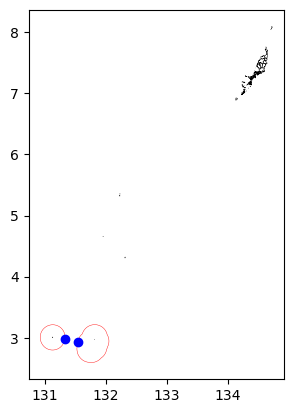

In [94]:
fig, ax = plt.subplots()

#merged hatohobei and hocharihie
merged_final_cont['geometry'][[0,3]].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
# pt1.plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
#8.608144 134.581725
#7.00000 133.727181

# Create a GeoDataFrame for the points
points_gdf1 = gpd.GeoDataFrame(geometry=[Point(pt.x, pt.y) for pt in [pt1,pt2]], crs='EPSG:4326')

# Plot the points
points_gdf1.plot(ax=ax, color='blue', marker='o')

plt.show()

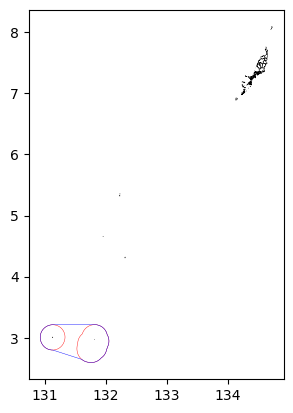

In [112]:
fig, ax = plt.subplots()

#merged hatohobei and hocharihie
merged_final_cont['geometry'][[0,3]].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
# pt1.plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
#8.608144 134.581725
#7.00000 133.727181

# # Create a GeoDataFrame for the points
# points_gdf1 = gpd.GeoDataFrame(geometry=[poly], crs='EPSG:4326')



# # Plot the points
# points_gdf1.plot(ax=ax, color='blue', marker='o')

merged_tobi = unary_union([poly,merged_final_cont['geometry'][0],merged_final_cont['geometry'][3]])

# Create a GeoDataFrame for the points
tobi_gdf = gpd.GeoDataFrame(geometry=[merged_tobi], crs='EPSG:4326')



# Plot the points
tobi_gdf.plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

plt.show()

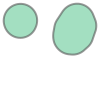

In [245]:
merged_final_cont['geometry'][0].convex_hull.union(merged_final_cont['geometry'][3].convex_hull)

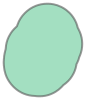

In [244]:
merged_final_cont['geometry'][0].difference(merged_final_cont['geometry'][3])

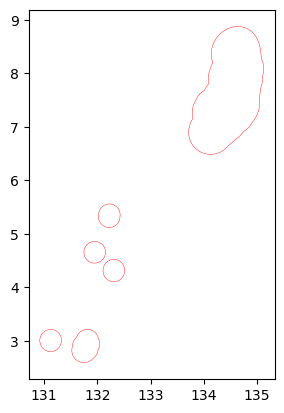

In [126]:
fig, ax = plt.subplots()

merged_final_cont['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
plt.show()

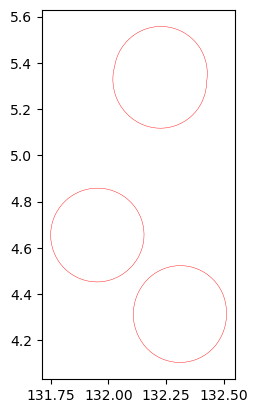

In [131]:
fig, ax = plt.subplots()

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)
plt.show()

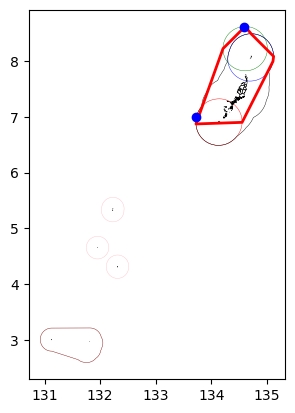

In [141]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

# merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)
# merged_oceanic_reefs.plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=1)


political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

merged_political_boundary['geometry'][[1]].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)

# Define the coordinates of the points
points_coords = [(8.608144, 134.581725), (7.00000, 133.727181)]

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for y, x in points_coords], crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='blue', marker='o')

tobi_gdf.plot(ax=ax, edgecolor = "maroon", facecolor= "none",lw=0.3)

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "pink", facecolor= "none",lw=0.3)






plt.show()

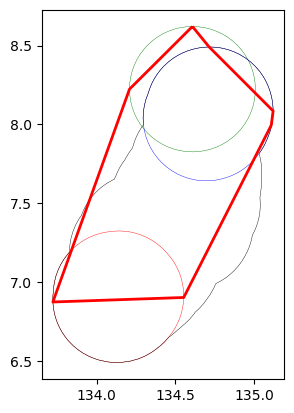

In [144]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

merged_political_boundary['geometry'][[1]].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)

plt.show()

In [179]:
main_land = pd.concat([merged_ngeruangel['geometry'],

merged_kayangel['geometry'],

merged_angaur['geometry'],

merged_political_boundary['geometry'][[1]],

bb['geometry']], ignore_index=True, axis=0).to_frame()
main_land.columns = ["geometry"]

/opt/anaconda3/envs/cmip6/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


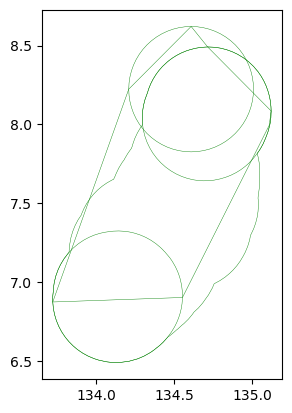

In [182]:
fig, ax = plt.subplots()

main_land['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)



plt.show()

In [185]:
# Identify overlapping circles
overlapping_groups = True

merged_main_land = main_land
# Loop until there are no more overlapping groups
while overlapping_groups:
    overlapping_groups, nonoverlapping_groups = find_overlapping_circles(merged_main_land)
    
    # Merge overlapping circles into single shapes
    merged_shapes = []
    for group in overlapping_groups:
        shapes_to_merge = [merged_main_land.loc[idx].geometry for idx in group]
        merged_shape = unary_union(shapes_to_merge)
        merged_shapes.append(merged_shape)

    # Retrieve non-overlapping shapes
    nonmerged_shapes = [merged_main_land.loc[group].geometry for group in nonoverlapping_groups]

    # Create a new GeoDataFrame with merged shapes
    merged_main_land = gpd.GeoDataFrame(geometry=merged_shapes + nonmerged_shapes, crs=political_boundary.crs)


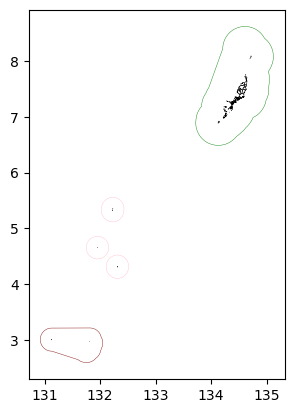

In [190]:
fig, ax = plt.subplots()

merged_main_land['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)


tobi_gdf.plot(ax=ax, edgecolor = "maroon", facecolor= "none",lw=0.3)

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "pink", facecolor= "none",lw=0.3)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)






plt.show()

In [200]:
df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

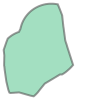

In [201]:
eez

In [219]:
p1 = geometry.Point(129.650253-1, 7.00)
p2 = geometry.Point(131.760439, 10.00)

p3 = geometry.Point(134.581725,8.608144)

p4 = geometry.Point(133.727181,7 )
# p5 = geometry.Point(133.297137,7.00)
# p6 = geometry.Point(133.467301,7.50)
# p7 = geometry.Point(133.807573,8.00)
# p8 = geometry.Point(134.16551,8.721375)

# p9 = geometry.Point(134.68167,9.200935)
# p10 = geometry.Point()

pointList = [p1, p2, p3, p4]
# , p5,p6,p7,p8,p9,p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

sdf = pd.DataFrame(
    {
        "Country": ["Palau"],
        "geometry": [poly
        ],
    }
)
new_palau_domestic_fishing = gpd.GeoDataFrame(sdf, geometry="geometry")

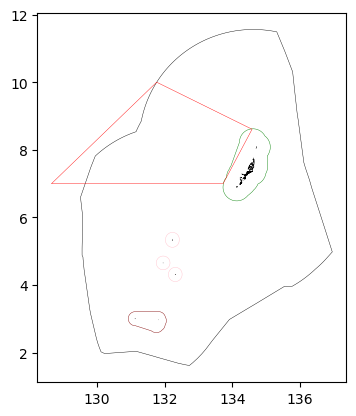

In [220]:
fig, ax = plt.subplots()

merged_main_land['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)


tobi_gdf.plot(ax=ax, edgecolor = "maroon", facecolor= "none",lw=0.3)

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "pink", facecolor= "none",lw=0.3)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

df_eez['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

new_palau_domestic_fishing['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)







plt.show()

In [264]:
merged_shape = unary_union([merged_main_land.geometry[0], new_palau_domestic_fishing.geometry[0]])

merged_fishing = gpd.GeoDataFrame(geometry=[merged_shape], crs=merged_main_land.crs)


# merged_fishing.geometry[0].difference(df_eez.geometry[0])
int_shape = df_eez.geometry[0].difference(sdf.geometry[0])

# int_shape = int_shape.difference(merged_main_land.geometry[0])

int_shape = merged_main_land.geometry[0].union(int_shape)


npdf = gpd.GeoDataFrame(geometry=[df_eez.geometry[0].difference(int_shape)], crs=merged_main_land.crs)

In [246]:
# npdf = gpd.GeoDataFrame(geometry=[int_shape], crs=merged_main_land.crs)
#

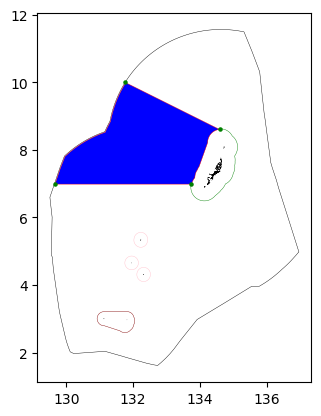

In [282]:
fig, ax = plt.subplots()

merged_main_land['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)


tobi_gdf.plot(ax=ax, edgecolor = "maroon", facecolor= "none",lw=0.3)

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "pink", facecolor= "none",lw=0.3)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

df_eez['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
# ishape.plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=0.3)

# merged_fishing['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=0.3)


npdf['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "blue",lw=0.3)


# Define the coordinates of the points
points_coords = [(10.00,131.760439),(7.0, 129.650253),(8.608144, 134.581725), (7.00000, 133.727181)]

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for y, x in points_coords], crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='green', marker='o', markersize = 5)


plt.show()

In [283]:
short_main_land = merged_main_land
short_main_land = short_main_land.to_crs(epsg=3395)
short_main_land['geometry'] = short_main_land.buffer(-12 * 1852)  # 1 nautical mile = 1852 meters
short_main_land = short_main_land.to_crs(epsg=4326)

In [313]:
merged_shape = unary_union([merged_main_land.geometry[0], new_palau_domestic_fishing.geometry[0]])

merged_fishing = gpd.GeoDataFrame(geometry=[merged_shape], crs=merged_main_land.crs)


# merged_fishing.geometry[0].difference(df_eez.geometry[0])
int_shape = df_eez.geometry[0].difference(sdf.geometry[0])

int_shape = int_shape.difference(merged_main_land.geometry[0])

# int_shape = merged_main_land.geometry[0].union(int_shape)


inpdf = gpd.GeoDataFrame(geometry=[df_eez.geometry[0].difference(int_shape)], crs=merged_main_land.crs)

In [321]:
protected_area = df_eez.geometry[0].difference(df_eez.geometry[0].difference(int_shape))
protected = gpd.GeoDataFrame(geometry=[protected_area], crs=merged_main_land.crs)

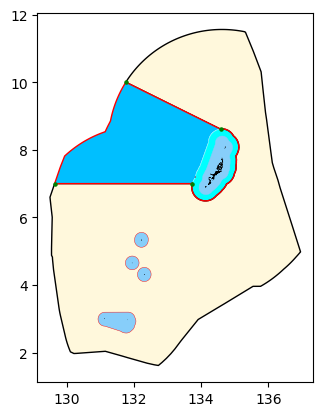

In [326]:
fig, ax = plt.subplots()

merged_main_land['geometry'].plot(ax=ax, edgecolor = "cyan", facecolor= "cyan",lw=0.3)

short_main_land['geometry'].plot(ax=ax, edgecolor = "lightskyblue", facecolor= "lightskyblue",lw=0.3)




# df_eez['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)
protected['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "cornsilk",lw=1)

# ishape.plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

# merged_fishing['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=0.3)


npdf['geometry'].plot(ax=ax, edgecolor = "none", facecolor= "deepskyblue",lw=1)

inpdf['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=1)


# Define the coordinates of the points
points_coords = [(10.00,131.760439),(7.0, 129.650253),(8.608144, 134.581725), (7.00000, 133.727181)]

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for y, x in points_coords], crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='green', marker='o', markersize = 5)

tobi_gdf.plot(ax=ax, edgecolor = "red", facecolor= "lightskyblue",lw=0.3)

merged_final_cont['geometry'][[2,4,5]].plot(ax=ax, edgecolor = "red", facecolor= "lightskyblue",lw=0.3)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)


plt.show()

In [346]:
fishing_zone = df_eez.geometry[0].difference(npdf.geometry[0])

fishing_zone = fishing_zone.difference(merged_main_land.geometry[0])

fishing_zone = fishing_zone.difference(tobi_gdf.geometry[0])

fishing_zone = fishing_zone.difference(merged_final_cont.geometry[2])

fishing_zone = fishing_zone.difference(merged_final_cont.geometry[4])

fishing_zone = fishing_zone.difference(merged_final_cont.geometry[5])


# fishing_zone = fishing_zone.difference(merged_final_cont.geometry[0])

fishing_zone_gpd = gpd.GeoDataFrame(geometry=[fishing_zone], crs=merged_main_land.crs)




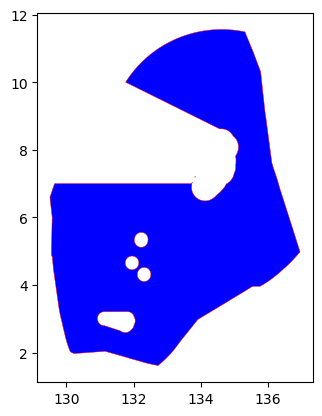

In [347]:
fig, ax = plt.subplots()


fishing_zone_gpd['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "blue",lw=0.3)

plt.show()

In [349]:
short_zone = gpd.GeoDataFrame(geometry=[short_main_land.geometry[0],tobi_gdf.geometry[0],merged_final_cont.geometry[2],merged_final_cont.geometry[4],merged_final_cont.geometry[5]], crs=merged_main_land.crs)


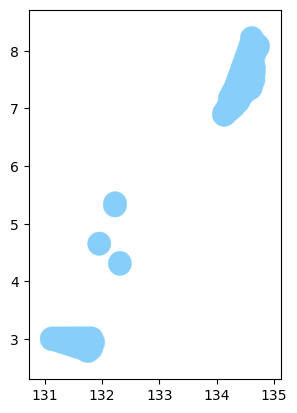

In [350]:
fig, ax = plt.subplots()
short_zone['geometry'].plot(ax=ax, edgecolor = "lightskyblue", facecolor= "lightskyblue",lw=0.3)
plt.show()

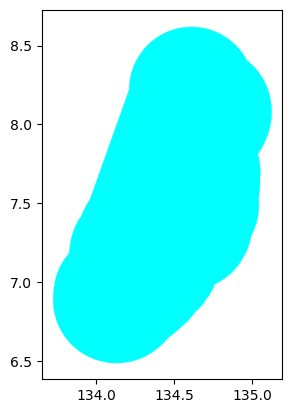

In [352]:
fig, ax = plt.subplots()
merged_main_land['geometry'].plot(ax=ax, edgecolor = "cyan", facecolor= "cyan",lw=0.3)
plt.show()

In [354]:
fishing_zone_gpd

,geometry
0,"MULTIPOLYGON (((135.31244 11.48818, 135.55076 ..."


In [356]:
fishing_zone_gpd.to_pickle('fishing_zone.pkl')

short_zone.to_pickle('12km_zone.pkl')

merged_main_land.to_pickle('24km_zone.pkl')

In [ ]:
main_land = pd.concat([merged_ngeruangel['geometry'],

merged_kayangel['geometry'],

merged_angaur['geometry'],

merged_political_boundary['geometry'][[1]],

bb['geometry']], ignore_index=True, axis=0).to_frame()
main_land.columns = ["geometry"]

In [ ]:
p

In [ ]:
merged_ngeruangel['geometry']

merged_kayangel['geometry']

merged_angaur['geometry']

merged_political_boundary['geometry'][[1]]

bb['geometry']

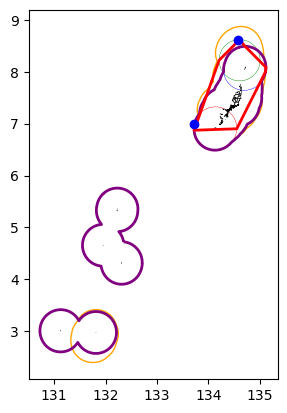

In [219]:
fig, ax = plt.subplots()

merged_ngeruangel['geometry'].plot(ax=ax, edgecolor = "green", facecolor= "none",lw=0.3)

merged_kayangel['geometry'].plot(ax=ax, edgecolor = "blue", facecolor= "none",lw=0.3)

merged_angaur['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=0.3)

# merged_reefs['geometry'].plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=0.3)
merged_oceanic_reefs.plot(ax=ax, edgecolor = "orange", facecolor= "none",lw=1)


merged_political_boundary['geometry'].plot(ax=ax, edgecolor = "purple", facecolor= "none",lw=2)

political_boundary['geometry'].plot(ax=ax, edgecolor = "black", facecolor= "none",lw=0.3)

bb['geometry'].plot(ax=ax, edgecolor = "red", facecolor= "none",lw=2)

# Define the coordinates of the points
points_coords = [(8.608144, 134.581725), (7.00000, 133.727181)]

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for y, x in points_coords], crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='blue', marker='o')




plt.show()

In [189]:
short_merged_political_boundary['geometry'][1:]

1    POLYGON ((132.01990 5.31797, 132.01933 5.32677...
2    POLYGON ((130.93133 2.94266, 130.92552 2.96326...
3    POLYGON ((131.61202 2.96863, 131.61171 2.97417...
4    POLYGON ((131.90301 4.85196, 131.92124 4.85570...
5    POLYGON ((132.12646 4.22659, 132.12472 4.23001...
Name: geometry, dtype: geometry

In [163]:
coral_reefs['l2_attrib'].unique()

array(['Oceanic Bank', 'Oceanic atoll', 'Oceanic island', 'main land',
       'aquatic land features'], dtype=object)

In [ ]:
##Ngeruangel Reef (Northernmost) x
#Kayangel Island (Northernmost and Eastern most) x
#Babeldaob barrier reef (south to the eastern most point)
#Anguar Island (south to the easternmost point) - (and around the island to its westernmost point) x
#Ngeruangel Reef (north to the westernmost point) - (and then around the reef to the point of origin) x

#List of Southwest Islands
#Fanna
#Sonsorol (Dongosaro)
#Pulo Anna and Merir
#Hatohobei (Tobi Island) 
    #- including Hocharihic (Helen's Reef)

In [94]:
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import MultiPoint

# Assuming bc_gdf is your GeoDataFrame containing circles
# Identify overlapping circles
overlapping_groups = []
nonoverlapping_shapes = []
for idx, circle1 in buffered_political_boundary.iterrows():
    if idx not in [item for sublist in overlapping_groups for item in sublist]:  # Skip if already merged
        overlaps = [idx]
        for jdx, circle2 in buffered_political_boundary.iterrows():
            if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                overlaps.append(jdx)
        if len(overlaps) > 1:  # Only consider merging if there are overlaps
            overlapping_groups.append(overlaps)
        else:
            nonoverlapping_shapes.append(circle1.geometry)

# Find connected components of overlapping circles
connected_components = []
visited = set()
for group in overlapping_groups:
    connected_component = []
    for idx in group:
        if idx not in visited:
            connected_component.append(idx)
            visited.add(idx)
            for jdx, circle2 in buffered_political_boundary.iterrows():
                if idx != jdx and circle1.geometry.intersects(circle2.geometry):
                    connected_component.append(jdx)
                    visited.add(jdx)
    if connected_component:
        connected_components.append(connected_component)

# Merge circles within each connected component
merged_shapes = []
for component in connected_components:
    shapes_to_merge = [buffered_political_boundary.loc[idx].geometry for idx in component]
    merged_shape = unary_union(shapes_to_merge)
    merged_shapes.append(merged_shape)

# Create separate GeoDataFrame for each connected component
merged_gdfs = [gpd.GeoDataFrame(geometry=[shape], crs=buffered_political_boundary.crs) for shape in merged_shapes]

# Combine all GeoDataFrames
merged_gdfs.extend([gpd.GeoDataFrame(geometry=[shape], crs=buffered_political_boundary.crs) for shape in nonoverlapping_shapes])
merged_political_boundary = gpd.GeoDataFrame(pd.concat(merged_gdfs, ignore_index=True), crs=buffered_political_boundary.crs)
